In [1]:
import os
import sys
import copy
import json
import math
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx
import geopandas as gpd
import matplotlib.pyplot as plt

from tqdm import tqdm
from shapely.geometry import shape, mapping, Point
from dijkstar import Graph, find_path

# Import data

In [2]:
# Choose origin and destination
origin = 'ward'
destination = 'borough'
size = 'small'
if size == 'small':
    size += '_'

In [3]:
# Import coordinates to get names and ids of wards and boroughs
origin_coords = gpd.read_file(f'../data/input/misc/london_{origin}_vertices.geojson')
destination_coords = gpd.read_file(f'../data/input/misc/london_{destination}_vertices.geojson')

In [34]:
# Import vertices
with open(f'../data/input/misc/london_{origin}_vertices.geojson') as json_file:
    origin_nodes = json.load(json_file)
with open(f'../data/input/misc/london_{destination}_vertices.geojson') as json_file:
    destination_nodes = json.load(json_file)
with open(f'../data/input/misc/london_{size}network_vertices.geojson') as json_file:
    london_nodes = json.load(json_file)
originswards = np.loadtxt('../data/input/commuter_ward/origins.txt',dtype=str) 

In [5]:
# Import edges
with open(f'../data/input/misc/london_ward_borough_to_{size}network_edges.geojson') as json_file:
    od_edges = json.load(json_file)
with open(f'../data/input/misc/london_{size}network_edges.geojson') as json_file:
    london_edges = json.load(json_file)
with open(f'../data/input/misc/london_{size}network_triangulated_edges.geojson') as json_file:
    triangulated_london_edges = json.load(json_file)

In [6]:
# Get unique ids
origin_vids = [str(x['properties']['ID']) for x in origin_nodes['features']]
destination_vids = [str(x['properties']['ID']) for x in destination_nodes['features']]
network_vids = [str(x['properties']['VERTEX_ID']) for x in london_nodes['features']]

network_eids = [str(x['properties']['EDGE_ID']) for x in london_edges['features']]
od_eids = [str(x['properties']['ID']) for x in od_edges['features']]

In [8]:
# Sanity checks
if len(origin_vids) != len(set(origin_vids)):
    print('Origin vertex ids are not unique')
if len(destination_vids) != len(set(destination_vids)):
    print('Destination vertex ids are not unique')
if len(network_vids) != len(set(network_vids)):
    print('Network vertex ids are not unique')
    
all_vids = np.sort(list(origin_vids+destination_vids+network_vids))
if len(all_vids) != len(set(all_vids)):
    print('There are vertex id inconsistencies between network and OD nodes')
all_vids = list(set(all_vids))
    
if len(od_eids) != len(set(od_eids)):
    print('Origin/Destination edge ids are not unique')
if len(network_eids) != len(set(network_eids)):
    print('Network edge ids are not unique')

all_eids = np.sort(list(set(network_eids)))
if len(all_eids) != len(set(all_eids)):
    print('There are edge id inconsistencies between network and OD nodes')

In [9]:
# Create hashmaps for vertex ids
vertex_ids_map = dict(zip(list(all_vids),range(1,len(all_vids)+1)))
vertex_ids_inverse_map = {v: k for k, v in vertex_ids_map.items()}

In [11]:
# Create geopandas from network nodes
london_node_properties = []
for node in tqdm(london_nodes['features']):
    node_properties = node['properties']
    node_properties['geometry'] = shape(node['geometry'])
    london_node_properties.append(node_properties)

london_nodes_df = gpd.GeoDataFrame(london_node_properties,crs="EPSG:4326")
london_edge_mapping = london_nodes_df[['EDGE_ID','VERTEX_ID']].groupby('EDGE_ID')['VERTEX_ID'].apply(list).reset_index(name='VERTEX_IDS')
london_edge_map = london_edge_mapping.set_index('EDGE_ID').to_dict()

100%|██████████| 38186/38186 [00:01<00:00, 26181.08it/s]


# Construct Graph

In [12]:
# Useful function
def extract_vertices_from_edge(x):
    vertices = london_edge_mapping[london_edge_mapping['EDGE_ID']==x].VERTEX_IDS.values[0]
    if len(vertices) != 2:
        print(x)
        raise Exception(f'Edge has {len(vertices)} instead of 2 vertices.')
    
    return vertices[0],vertices[1]

In [13]:
# Flag to create or load the graph
create_graph = False

In [27]:
if create_graph:
    # Initialise graph
    g = nx.Graph() # nx.complete_graph(network_vids)
    
    # Add vertices
    g.add_nodes_from(all_vids)
    
    od_edges_list = []
    # Add all origin/destination to network edges
    for edge in tqdm(od_edges['features']):

        # Get vertices of edge
        v_i = edge['properties']["ID"]#vertex_ids_map[edge['properties']["ID"]]
        v_j = edge['properties']["VERTEX_ID"]#vertex_ids_map[edge['properties']["VERTEX_ID"]]

        # Get cost of edge
        cost = edge['properties']["DISTANCE"]
        
        if cost is None:
            print(json.dumps(edge, indent = 2))

        # Add edge to graph
        g.add_edge(v_i,v_j,weight=cost)
#         od_edges_list.append((v_i,v_j,cost))

        # Change edge cost
#         g[v_i][v_j]['weight'] = cost
    
    # Add edges to graph
#     g.add_weighted_edges_from(od_edges_list)
    
    
    network_edges_list = []
    # Add all network edges
    for edge in tqdm(london_edges['features']):
        # print(json.dumps(edge, indent = 2))

        # Get vertices of edge
        v_i,v_j = extract_vertices_from_edge(edge['properties']["EDGE_ID"])

        # Map string to vertex number
#         v_i = vertex_ids_map[v_i]
#         v_j = vertex_ids_map[v_j]

        # Get cost of edge
        cost = edge['properties']["DISTANCE"]
        
        if v_i is None or v_j is None or cost is None:
            print(json.dumps(edge, indent = 2))

        # Add edge to graph
        g.add_edge(v_i,v_j,weight=cost)
#         network_edges_list.append((v_i,v_j,cost))
        # Change edge cost
#         g[v_i][v_j]['weight'] = cost
    
    # Add edges to graph
#     g.add_weighted_edges_from(network_edges_list)

    # Add all origin/destination to network edges
    for edge in tqdm(triangulated_london_edges['features']):

        # Get vertices of edge
        v_i = edge['properties']["ID1"]
        v_j = edge['properties']["ID2"]

        # Get cost of edge
        cost = edge['properties']["DISTANCE"]
        
        if cost is None:
            print(json.dumps(edge, indent = 2))

        # Add edge to graph
        g.add_edge(v_i,v_j,weight=cost)
        
    
    print('Writing graph to file')
    # Write Graph to pickle
    nx.write_gpickle(g, f"../data/input/misc/london_{size}tranport_network_graph.gpickle")
    
    # Make graph undirected
    G = g.to_undirected()
    
else:
    print('Loading graph from file')
    # Read graph from file
    g = nx.read_gpickle(f"../data/input/misc/london_{size}tranport_network_graph.gpickle")

    # Make graph undirected
    G = g.to_undirected()
    
    # Preprocess od edges
    # Convert to dataframe
    od_edge_df = pd.DataFrame.from_records(od_edges['features'])
    # Drop unnecesary columns
    od_edge_df = od_edge_df.drop(columns=['type'])
    # Unpack properties
    od_edge_df = od_edge_df.join(od_edge_df['properties'].apply(pd.Series))

Loading graph from file


In [29]:
# od_network_vertices = [x[1] for x in od_edges_list]

# network_vertices0 = [x[0] for x in network_edges_list]
# network_vertices1 = [x[1] for x in network_edges_list]
# network_vertices = network_vertices0+network_vertices1

In [30]:
# for od_network_vertex in tqdm(od_network_vertices):
#     if od_network_vertex not in network_vertices:
#         print('inconsistency')
#         a=0
#     else:
#         a=1
# #         print('consistency')
# #         print(od_network_vertex)
    

In [31]:
# Visualise graph 

# nx.draw(g,with_labels=True,with_weight=True)
# plt.show()

# Construct cost matrix

In [40]:
# Get new ward,borough names
origins = np.sort(origin_coords['NAME'].unique())
destinations = np.sort(destination_coords['NAME'].unique())

# Initialise empty cost dataframe
cost_matrix = pd.DataFrame(0, index=origins, columns=destinations)
# Sort dataframe by index
cost_matrix = cost_matrix.sort_index(axis=1).sort_index(axis=0)

In [41]:
# Loop over cost matrix rows
for origin,row in tqdm(cost_matrix.iterrows(),total=cost_matrix.shape[0]):
    # Compute distance between centroids for entries off the diagonal
    for destination in destinations:
        # Get ward_code and borough_code
        ward_code = origin_coords[origin_coords['NAME']==origin]['ID'].values[0]
        borough_code = destination_coords[destination_coords['NAME']==destination]['ID'].values[0]
        
        # Get source (origin) edge number and target (destination) edge number
#         source_num = int(vertex_ids_map[ward_code])
#         target_num = int(vertex_ids_map[borough_code])
    
#         print('source_num',source_num)
#         print('target_num',target_num)
        
        if not G.has_node(ward_code) or not G.has_node(borough_code):
            if not G.has_node(ward_code):
                print(f'Vertex {origin} ({ward_code}) has not been added to the graph.')
            else:
                print(f'Vertex {destination} ({borough_code}) has not been added to the graph.')
        else:
            if not nx.has_path(G,source=ward_code,target=borough_code):
                print(f'NO path from {origin} ({ward_code}) to {destination} ({borough_code})')
                continue
            else:
#                 print('computing cost')
                cost_matrix.loc[origin,destination] = nx.dijkstra_path_length(G,source=ward_code,target=borough_code,weight='weight')

  2%|▏         | 12/628 [01:06<57:17,  5.58s/it]


KeyboardInterrupt: 

In [22]:
cost_matrix.shape

(628, 33)

In [27]:
pd.DataFrame(cost_matrix)

,Barking and Dagenham,Barnet,Bexley,Brent,Bromley,Camden,City of London,Croydon,Ealing,Enfield,...,Merton,Newham,Redbridge,Richmond upon Thames,Southwark,Sutton,Tower Hamlets,Waltham Forest,Wandsworth,Westminster
AbbeyRoad,24258,9608,25770,7316,25827,2205,7236,21633,12441,15023,...,14344,16870,20375,14771,10724,19837,11360,14281,9548,2723
AbbeyWood,6950,29372,4142,30206,14097,21766,15969,22386,33646,24088,...,26056,7542,11461,33165,14288,27218,12101,15429,23308,21002
Abbey_BarkingandDagenham,4594,24719,10495,26586,19283,18044,13249,24976,30880,18111,...,25825,3290,5265,31815,13835,28414,9060,9407,22574,18236
Abbey_Merton,29174,23128,25831,17586,19629,15369,13942,10687,16789,28248,...,898,21846,28514,10333,11378,6120,17075,24833,4376,11671
Abingdon,25394,13710,25311,8841,24507,6613,8250,18169,10347,19624,...,9876,18001,23064,11074,9666,15473,12620,17936,5184,3604
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WoolwichRiverside,9080,25271,7934,25976,13901,17536,11739,19108,29352,21272,...,21463,4423,10860,28532,9655,23495,7871,12840,18675,16772
WorcesterPark,34075,26922,30494,20519,21679,20060,18843,11679,18083,32951,...,4398,26747,33415,9751,16279,4781,21976,29734,8968,16362
WormholtandWhiteCity,28359,12125,28988,5965,28049,7542,11061,21504,7323,19879,...,12175,20966,25208,9896,13343,17826,15336,19528,8117,6042
Yeading,39645,18101,40274,10506,38691,18368,22347,30367,4616,28043,...,19844,32252,36538,10941,24629,24644,26622,30298,17866,17328


# Visualise cost matrix

In [54]:
normalised_cost_matrix = cost_matrix.values/np.sum(cost_matrix.values)

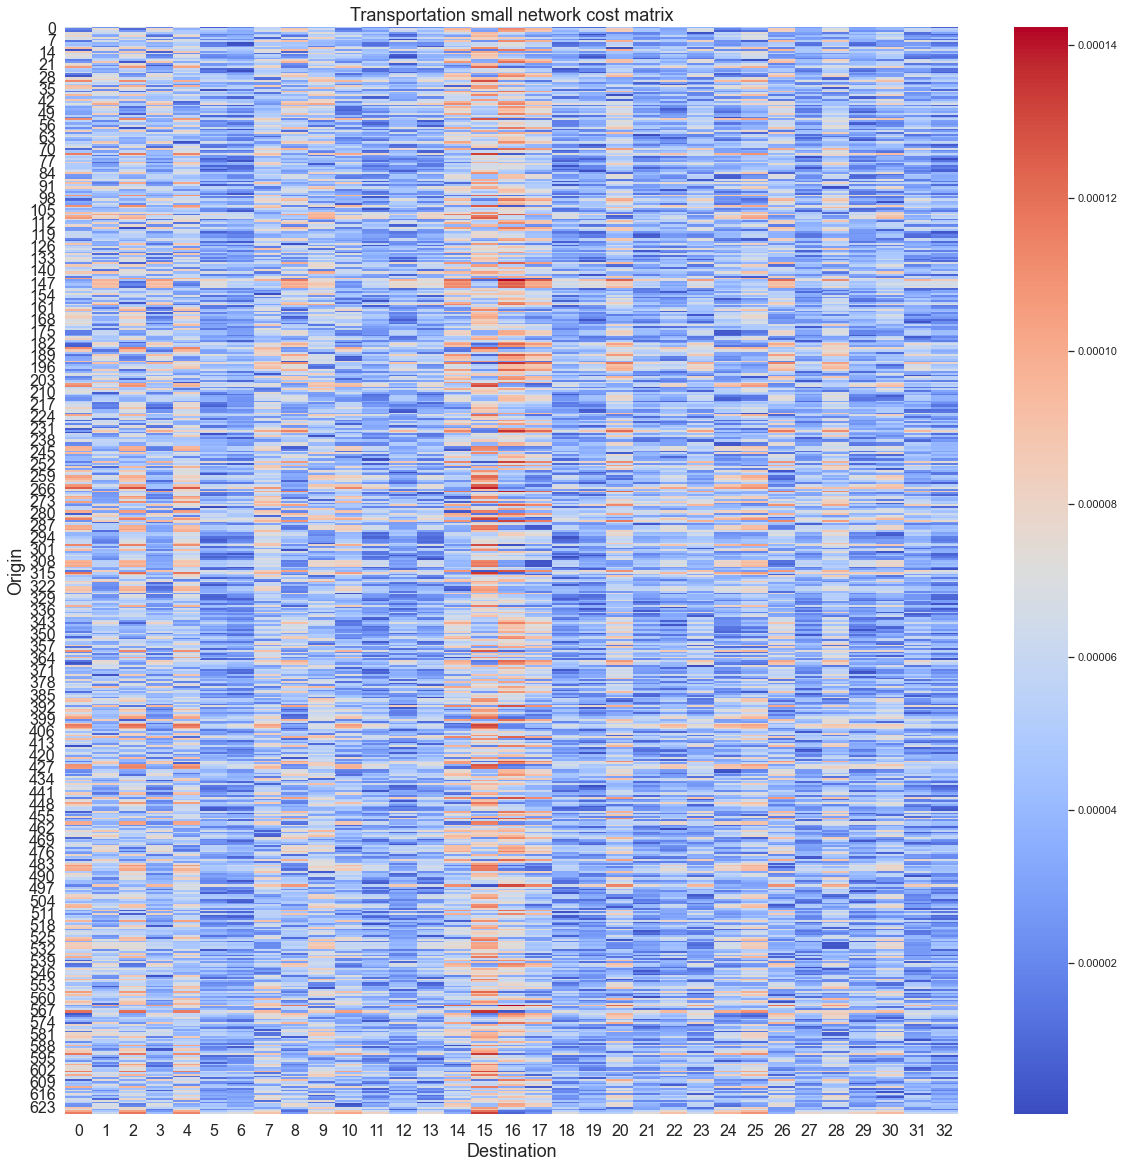

In [55]:
# Change font scaling
sns.set(font_scale=1)
# Set plot size
plt.figure(figsize=(20,20))
# Add heatmap
flow_heatmap = sns.heatmap(normalised_cost_matrix,
                            annot=False,
                            cmap="coolwarm")#,
                            #fmt='d',
                            #xticklabels=cost_matrix.index.values,
                            #yticklabels=cost_matrix.columns.values)
# Add x,y axes labels
plt.xlabel("Destination",fontsize=18)
plt.ylabel("Origin",fontsize=18)
# Add title
temp = size.replace('_','')
plt.title(f'Transportation {temp} network cost matrix', fontsize=18)
# Increase tick font size
plt.tick_params(labelsize=16)

In [56]:
# Import Euclidean based cost matrix
euclidean_cost_matrix = np.loadtxt('../data/input/commuter_ward/cost_matrix.txt')
normalised_euclidean_cost_matrix = euclidean_cost_matrix/np.sum(euclidean_cost_matrix)

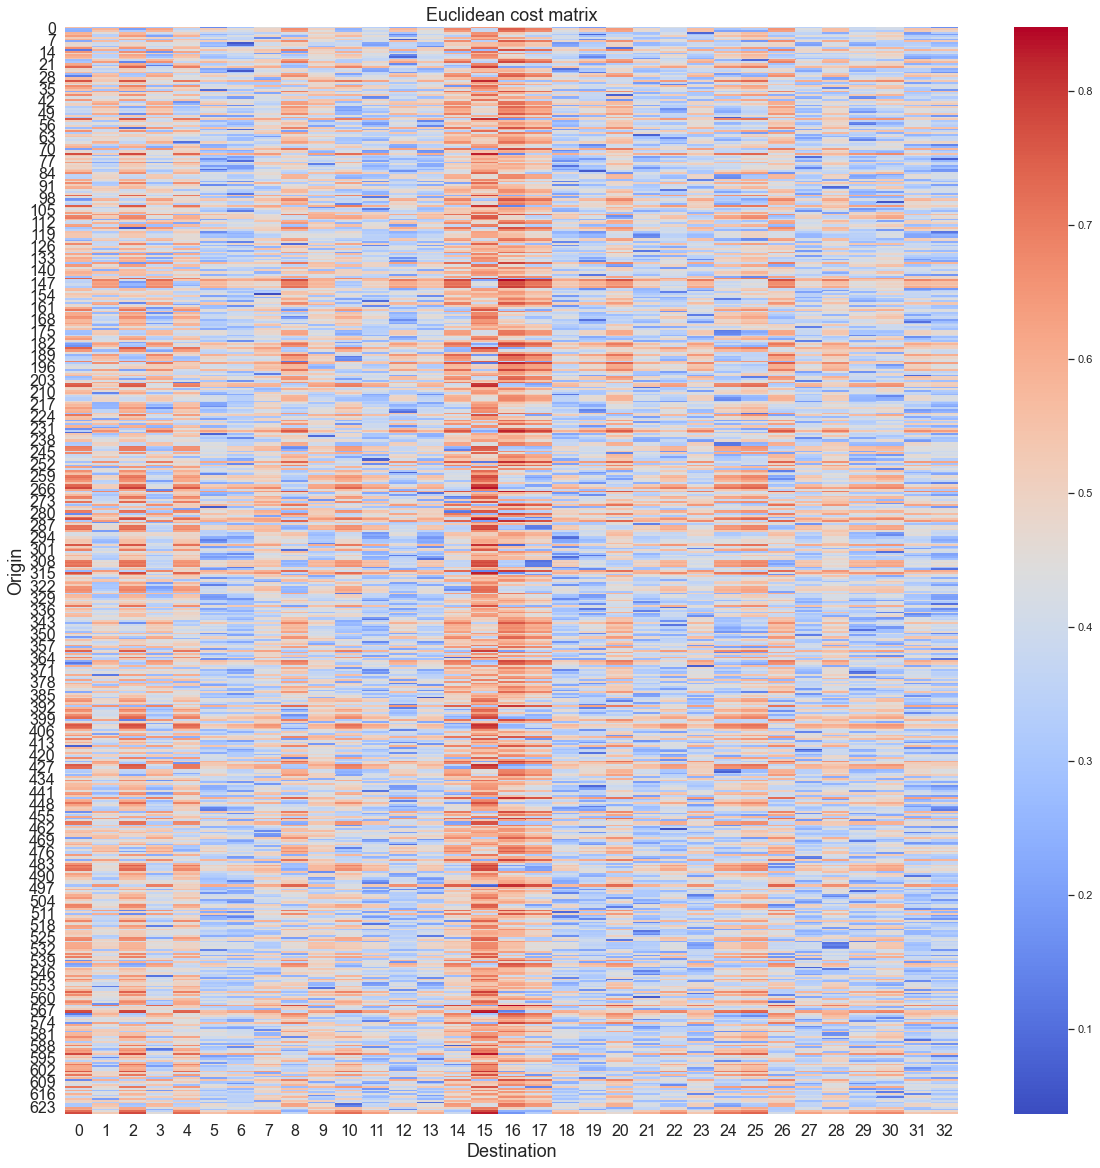

In [57]:
# Change font scaling
sns.set(font_scale=1)
# Set plot size
plt.figure(figsize=(20,20))
# Add heatmap
flow_heatmap = sns.heatmap(euclidean_cost_matrix,
                            annot=False,
                            cmap="coolwarm")
#                             ,
#                             yticklabels=cost_matrix.index.values,
#                             xticklabels=cost_matrix.columns.values)
# Add x,y axes labels
plt.xlabel("Destination",fontsize=18)
plt.ylabel("Origin",fontsize=18)
# Add title
plt.title(f'Euclidean cost matrix', fontsize=18)
# Increase tick font size
plt.tick_params(labelsize=16)

# Export cost matrix and Borough names as dataframe and numpy array

In [24]:
# Export to csv
cost_matrix.to_csv('../data/input/commuter_ward/cost_matrix_small_network.csv')
# Export to txt
np.savetxt('../data/input/commuter_ward/cost_matrix_small_network.txt',cost_matrix.to_numpy())